## AlexNet
#### 动手学深度学习 —— AlexNet
#### 使用 Pytorch 实现——yujia

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from d2l import torch as d2l

#### 数据集

In [2]:
resize = 224
trans = [transforms.ToTensor()]
trans.insert(0, transforms.Resize(resize))
trans = transforms.Compose(trans)

train_set = torchvision.datasets.FashionMNIST(
    root='../Dataset', #数据集下载后保存到本地的地址
    train=True, #是否为训练数据集
    download=True,  #是否下载，如果是第一次则需要下载
    transform=trans)#转为张量

test_set = torchvision.datasets.FashionMNIST(
    root='../Dataset', 
    train=False, 
    download=True, 
    transform=trans)

In [3]:
d2l.load_data_fashion_mnist??

In [4]:
batch_size = 64
num_workers = 1
classes = train_set.classes

train_iter = DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)

test_iter = DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)

#### AlexNet

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.AlexNet = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        y = self.AlexNet(x)
        return y
model = AlexNet()
model

AlexNet(
  (AlexNet): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=6400, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, out_features=4096, bias=True)
    (18): ReLU()
 

In [6]:
def evaluate_accuracy_gpu(model, data_iter, device=None):
    if isinstance(model, nn.Module):
        model.eval()
        if not device:
            device = next(iter(model.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(model(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
def train(model, train_iter, test_iter, num_epochs, lr, device):
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weight)
    print('training on', device)
    model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss', 'train_acc', 'test_acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for step, (X, y) in enumerate(train_iter):
            timer.start()
            opt.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            opt.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (step + 1) % (num_batches // 5) == 0 or step == num_batches-1:
                animator.add(epoch + (step+1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(model, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l: .3f}, train_acc {train_acc: .3f},'
            f'test_acc {test_acc: .3f}')
    print(f'{metric[2] * num_epochs / timer.sum(): .1f} examples/sec '
            f'on {str(device)}')

loss  0.277, train_acc  0.898,test_acc  0.898
 983.3 examples/sec on cuda:0


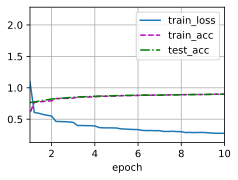

In [8]:
lr, num_epochs = 0.01, 10
train(model, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())